#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Поступила задача построить модель для такого предсказания.

Сделаем следующие:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами.
4. Проверим данные на тестовой выборке (метрики качества RMSE MAE) и сделаем выводы.


## Подготовка

In [ ]:
# Импортируем необходимые библиотеки

# Базовые библиотеки
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Визуализация
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Временные ряды
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from prophet import Prophet

# Предобработка данных
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# Модели машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Нейронные сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Загрузим данные и отсортируем их в порядке возрастания
df = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Данные состоят из двух столбцов:
- времени (данные указаны за каждые 10 минут);
- количество заказов

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# Проверим, в хронологическом ли порядке расположены данные
df.index.is_monotonic_increasing

True

In [ ]:
# Проверим, есть ли пропущенные значения
print(f"Всего пропусков: {df.isnull().sum().sum()}")



Всего пропусков: 0


In [ ]:
# Выполним ресемплирование данных по одному часу
df = df.resample('1H').sum()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Вывод:

Данные ресемплированы, расположены в хронологическом порядке

## Анализ

Проведем анализ данных. Скопируем данные для проведения анализа.

In [ ]:
new_df = df.copy()

Проверим стационарность данных с помощью теста Дики-Фуллера

In [ ]:
result = adfuller(new_df['num_orders'])

# Вывод результатов
adf_stat, p_value = result[0], result[1]
adf_stat, p_value

(-3.0689242890279482, 0.028940051402613506)

Так как значение p-value меньше 0.05, мы отвергаем нулевую гипотезу. Это означает, что данные стационарны.

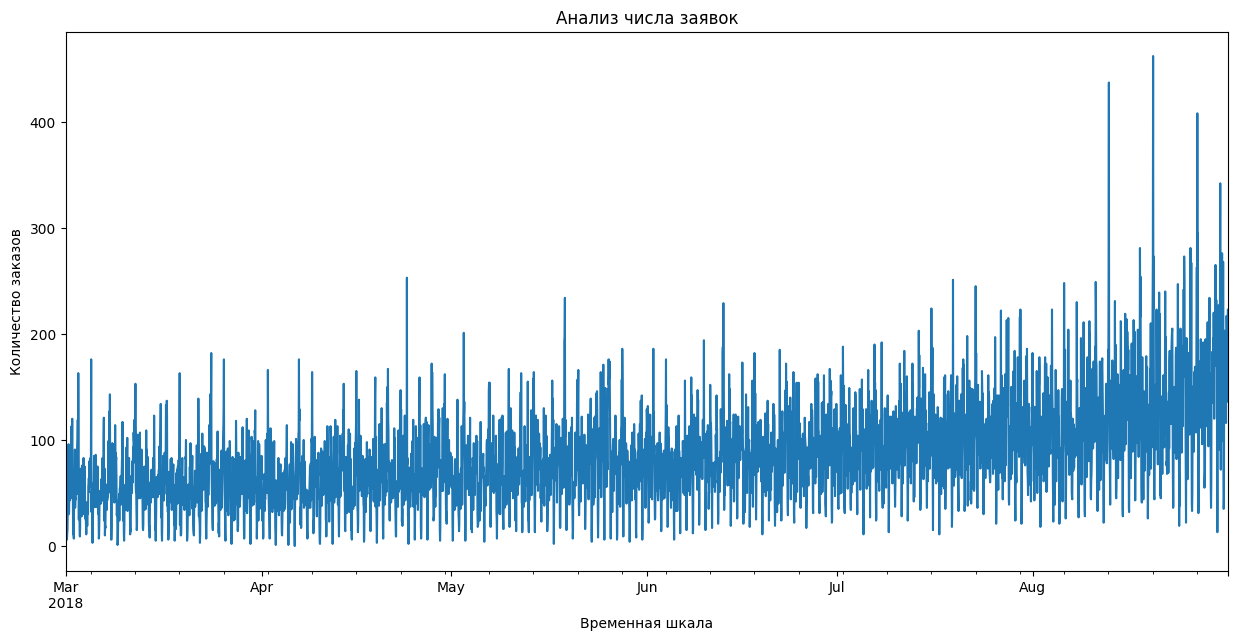

In [ ]:
new_df['num_orders'].plot(figsize=(15,7))
plt.title('Анализ числа заявок')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.show()

Наблюдается тенденция к увеличению количества заказов к концу наблюдаемого периода. Найдем скользящее среднее.

In [ ]:
# Добавляем скользящее среднее
new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(100).mean()

# Создаём график
fig = go.Figure()

# Исходные данные
fig.add_trace(go.Scatter(
    x=new_df.index,
    y=new_df['num_orders'],
    mode='lines',
    name='Число заказов',
    line=dict(color='blue')
))

# Скользящее среднее
fig.add_trace(go.Scatter(
    x=new_df.index,
    y=new_df['rolling_mean'],
    mode='lines',
    name='Скользящее среднее (100)',
    line=dict(color='orange')
))

# Настройка графика
fig.update_layout(
    title='Анализ числа заявок',
    xaxis_title='Временная шкала',
    yaxis_title='Количество заказов',
    template='plotly_white',
    height=800,
    width=1500
)

# Отображение графика
fig.show()

Среднее скользящее подтвердило нашу теорию об увеличении количества заказов к концу августа.

Проведем декомпозицию для просмотра тренда

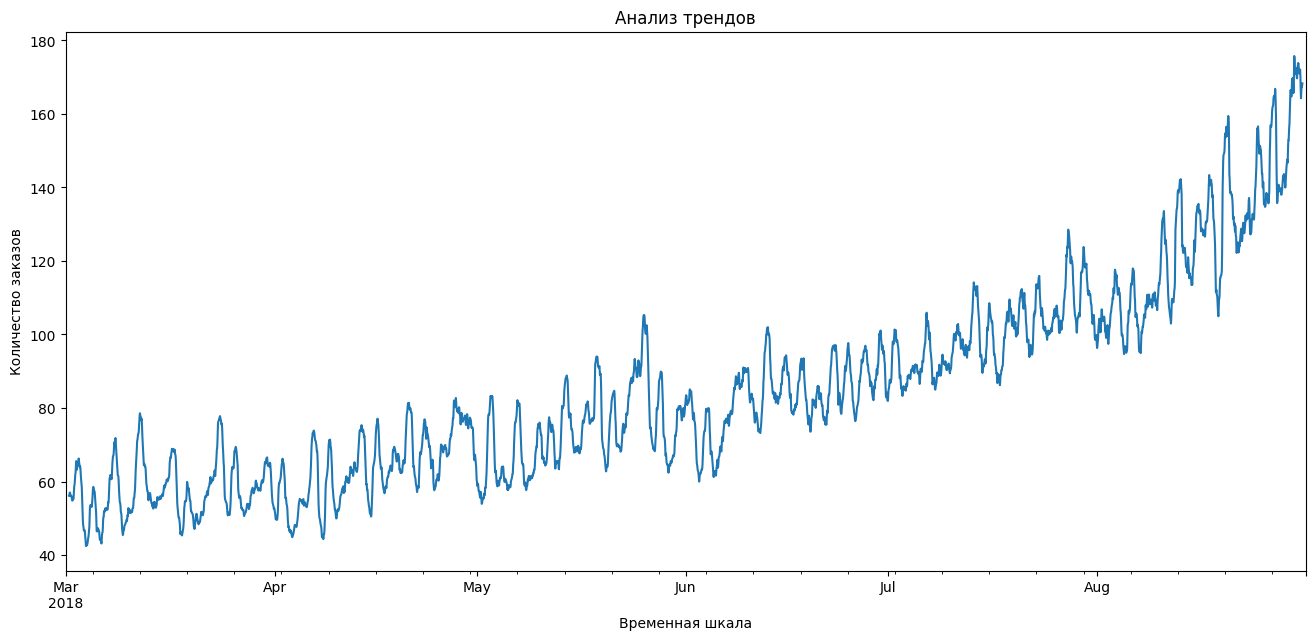

In [ ]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(figsize=(16,7))
plt.title('Анализ трендов')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.show()

Наблюдается восходящий тренд. Так как мы анализируем такси из аэропортов, то восходящий тренд может нам говорить о том, что в августе люди чаще всего отправляются в отпуск.

Рассмотрим сезонность на протяжении одного дня

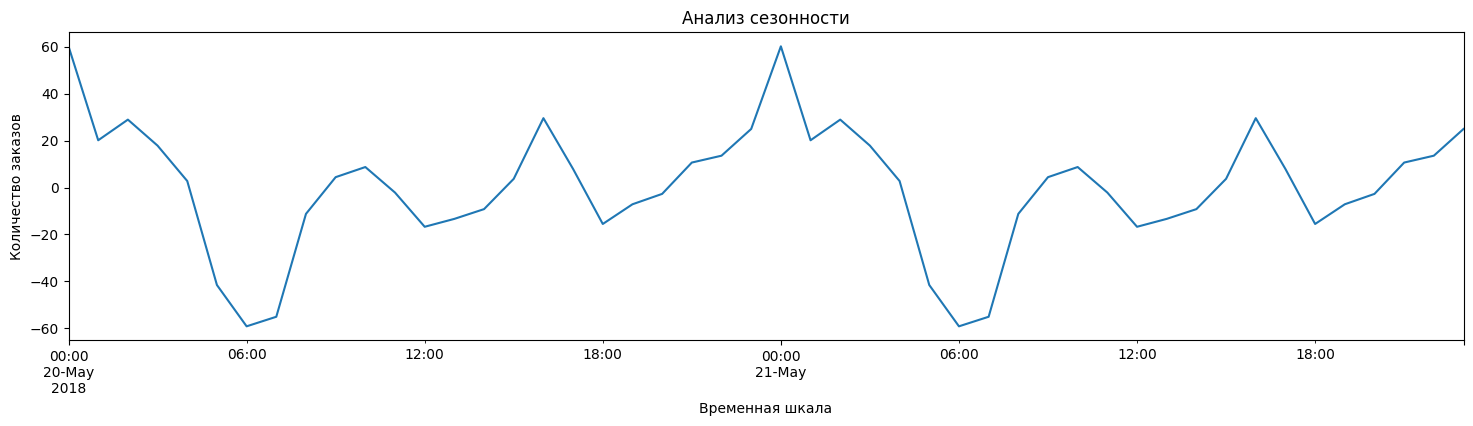

In [ ]:
plt.figure(figsize=(18, 4))
decomposed.seasonal['2018-05-20':'2018-05-21'].plot(ax=plt.gca())
plt.title('Анализ сезонности')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.show()

Как видно из графика пик заказов приходится на полночь. В 6 утра наименьшее число заказов.

## Поиск выбросов с использованием скользящего окна

In [ ]:
# Параметры скользящего окна
window_size = 24  # 24 часа

# Скользящее среднее и стандартное отклонение
rolling_mean = df['num_orders'].rolling(window=window_size).mean()
rolling_std = df['num_orders'].rolling(window=window_size).std()

# Определение границ
upper_bound = rolling_mean + 3 * rolling_std
lower_bound = rolling_mean - 3 * rolling_std

# Выявление выбросов
df['is_outlier'] = ((df['num_orders'] > upper_bound) | (df['num_orders'] < lower_bound))

# Просмотр выбросов
outliers = df[df['is_outlier'] == True]
print(f"Количество выбросов: {len(outliers)}")

Количество выбросов: 18


Значение не так велико относительно общего датасета, поэтому можно заменить выбросы скользящий средним значением.

In [ ]:
# Удалим временный столбец
df = df.drop(['is_outlier'], axis=1)

# Вычисляем скользящее среднее
rolling_mean = df['num_orders'].rolling(window=window_size, center=True).mean()

# Условие для выбросов
is_outlier = (df['num_orders'] < lower_bound) | (df['num_orders'] > upper_bound)

# Заменяем выбросы на значения скользящего среднего
df.loc[is_outlier, 'num_orders'] = rolling_mean[is_outlier]

# Сравниваем количество выбросов до и после
remaining_outliers = ((df['num_orders'] < lower_bound) | (df['num_orders'] > upper_bound)).sum()
print(f"Оставшиеся выбросы: {remaining_outliers}")

Оставшиеся выбросы: 0


## Обучение

Создадим новые признаки:

+ День недели (так как у нас есть недельная сезонность);
+ Час (Так как есть часовая (суточная) сезонность);
+ Лаги(отставания) (Это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние);
+ Скользящее среднее (Это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда).

In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    data =  df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    return data

In [ ]:
data = make_features(df, 10, 10)

In [ ]:
display(data)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,64.0,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96.0,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30.0,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32.0,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48.0,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136.0,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154.0,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159.0,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


Поделим данные на выборки

In [ ]:
# Разделим данные на тренировочную и тестовую выборку
train = data.iloc[:-31*24]  # Все данные, кроме последнего месяца
test = data.iloc[-31*24:]  # Последний меясц

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим, правильно ли разделили данные на выборки:

In [ ]:
print('Размер тренировочной выборки:', train.shape)

Размер тренировочной выборки: (3662, 14)


In [ ]:
train

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,64.0,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96.0,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30.0,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32.0,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48.0,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31 19:00:00,85.0,1,19,42.0,112.0,100.0,99.0,75.0,58.0,85.0,119.0,134.0,112.0,93.6
2018-07-31 20:00:00,98.0,1,20,85.0,42.0,112.0,100.0,99.0,75.0,58.0,85.0,119.0,134.0,90.9
2018-07-31 21:00:00,131.0,1,21,98.0,85.0,42.0,112.0,100.0,99.0,75.0,58.0,85.0,119.0,87.3


In [ ]:
print('Размер тестовой выборки:', test.shape)

Размер тестовой выборки: (744, 14)


In [ ]:
test

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-01 00:00:00,182.0,2,0,125.0,124.0,131.0,98.0,85.0,42.0,112.0,100.0,99.0,75.0,99.1
2018-08-01 01:00:00,98.0,2,1,182.0,125.0,124.0,131.0,98.0,85.0,42.0,112.0,100.0,99.0,109.8
2018-08-01 02:00:00,133.0,2,2,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,112.0,100.0,109.7
2018-08-01 03:00:00,95.0,2,3,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,112.0,113.0
2018-08-01 04:00:00,122.0,2,4,95.0,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,111.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136.0,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154.0,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159.0,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


**LinearRegression**

Обучим модель **LinearRegression**

In [ ]:
%%time

LR_model = LinearRegression(fit_intercept=True)
LR_model.fit(features_train, target_train)

CPU times: user 4.03 ms, sys: 1 µs, total: 4.03 ms
Wall time: 4.11 ms


LinearRegression()

**RandomForestRegressor**

Обучим модель **RandomForestRegressor** и подберем для нее наилучшие параметры с помощью GridSearchCV

In [ ]:
%%time

RF_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 20, 2)
        }
RF_grid = GridSearchCV(RandomForestRegressor(), param_grid = RF_params, refit=False, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=8))
RF_grid.fit(features_train, target_train)

RF_best_params = RF_grid.best_params_
RF_model = RandomForestRegressor(**RF_best_params, random_state=12345, verbose=0)
RF_model.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', RF_best_params)


Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 80}
CPU times: user 6min 15s, sys: 394 ms, total: 6min 15s
Wall time: 6min 16s


**LGBMRegressor**

Обучим модель **LGBMRegressor** и подберем для нее наилучшие параметры с помощью GridSearchCV

In [ ]:
%%time
LGB_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2)
        }
LGB_grid = GridSearchCV(LGBMRegressor(), param_grid = LGB_params, refit=False, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=8))
LGB_grid.fit(features_train, target_train)

LGB_best_params = LGB_grid.best_params_
LGB_model = LGBMRegressor(**LGB_best_params, random_state=12345, verbose=0)
LGB_model.fit(features_train, target_train)


print('Лучшие гиперпараметры: ', LGB_best_params)



## Тестирование

Проведем тестирование наших моделей

Сначала сделаем baseline, с которым будем проверять наши модели на адекватность

In [ ]:
# Используем скользящее среднее
window_size = 10
rolling_mean_forecast = target_test.rolling(window=window_size).mean().iloc[-1]
rolling_mean_forecast = [rolling_mean_forecast] * len(test)

print("RMSE тестовой выборки констанстной модели: ", mean_squared_error(target_test, rolling_mean_forecast)**0.5)
print("MAE тестовой выборки констанстной модели: ", mean_absolute_error(target_test, rolling_mean_forecast))

RMSE тестовой выборки констанстной модели:  71.32543514698008
MAE тестовой выборки констанстной модели:  60.203080197132614


In [ ]:
%%time
LR_pred = LR_model.predict(features_test)

print("RMSE тестовой выборки LinearRegression: ", mean_squared_error(target_test, LR_pred)**0.5)
print("MAE тестовой выборки LinearRegression: ", mean_absolute_error(target_test, LR_pred))

RMSE тестовой выборки LinearRegression:  46.77787763026992
MAE тестовой выборки LinearRegression:  36.576441983978256
CPU times: user 8.48 ms, sys: 2 ms, total: 10.5 ms
Wall time: 6.76 ms


In [ ]:
%%time
RF_pred = RF_model.predict(features_test)

print("RMSE тестовой выборки RandomForestRegressor: ", mean_squared_error(target_test, RF_pred)**0.5)
print("MAE тестовой выборки RandomForestRegressor: ", mean_absolute_error(target_test, RF_pred))

RMSE тестовой выборки RandomForestRegressor:  39.0956456764771
MAE тестовой выборки RandomForestRegressor:  29.082889677457295
CPU times: user 22.1 ms, sys: 13 µs, total: 22.1 ms
Wall time: 21.8 ms


In [ ]:
%%time
LGB_pred = LGB_model.predict(features_test)
print("RMSE тестовой выборки LGBMRegressor: ", mean_squared_error(target_test, LGB_pred)**0.5)
print("MAE тестовой выборки LGBMRegressor: ", mean_absolute_error(target_test, LGB_pred))

RMSE тестовой выборки LGBMRegressor:  39.27866975417988
MAE тестовой выборки LGBMRegressor:  29.001207238285904
CPU times: user 8.38 ms, sys: 7 µs, total: 8.38 ms
Wall time: 9.52 ms


Проверка классических моделей на тестовой выборке показала, что наилучшая модель, в соответствии с метрикой MAE, - LGBMRegressor (29.00).

Рассмотрим другие модели и подходы к решению задач временных рядов.




---



# Prophets

Применим модуль **Prophets** для анализа нашего исходного датасета и расчета предсказания на тестовых данных

In [ ]:
df = pd.read_csv('/content/taxi.csv', parse_dates=[0])
df.sort_index(inplace=True)
df.columns = ['ds', 'y']

In [ ]:
# Устанавливаем столбец 'ds' как индекс
df = df.set_index('ds')

# Применяем resample к индексу для группировки по часу
df = df.resample('H').sum()

# Сбрасываем индекс обратно
df = df.reset_index()

In [ ]:
df

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4416 non-null   datetime64[ns]
 1   y       4416 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 69.1 KB


In [ ]:
# Устраним выбросы
# Параметры скользящего окна
window_size = 4  # 4 часа

# Скользящее среднее и стандартное отклонение
rolling_mean = df['y'].rolling(window=window_size).mean()
rolling_std = df['y'].rolling(window=window_size).std()

# Определение границ
upper_bound = rolling_mean + 3 * rolling_std
lower_bound = rolling_mean - 3 * rolling_std

# Условие для выбросов
is_outlier = (df['y'] < lower_bound) | (df['y'] > upper_bound)

# Заменяем выбросы на значения скользящего среднего
df.loc[is_outlier, 'y'] = rolling_mean[is_outlier]


In [ ]:
# Разделим данные на тренировочную и тестовую выборку
train = df.iloc[:-31*24]  # Все данные, кроме последнего месяца
test = df.iloc[-31*24:]  # Последний меясц

In [ ]:
# Обучим модель на тренировочных данных
model = Prophet()
model.add_seasonality(name='daily', period=24, fourier_order=3)  # Добавление дневной сезонности
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd29g917/x3ycfk57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd29g917/a99n28gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57714', 'data', 'file=/tmp/tmpwd29g917/x3ycfk57.json', 'init=/tmp/tmpwd29g917/a99n28gs.json', 'output', 'file=/tmp/tmpwd29g917/prophet_model05jp8v8h/prophet_model-20250127123622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Построим прогноз на период, соответствующий тестовым данным
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

In [ ]:
# Выделим прогнозные значения для тестового периода
forecast_test = forecast.iloc[-len(test):]

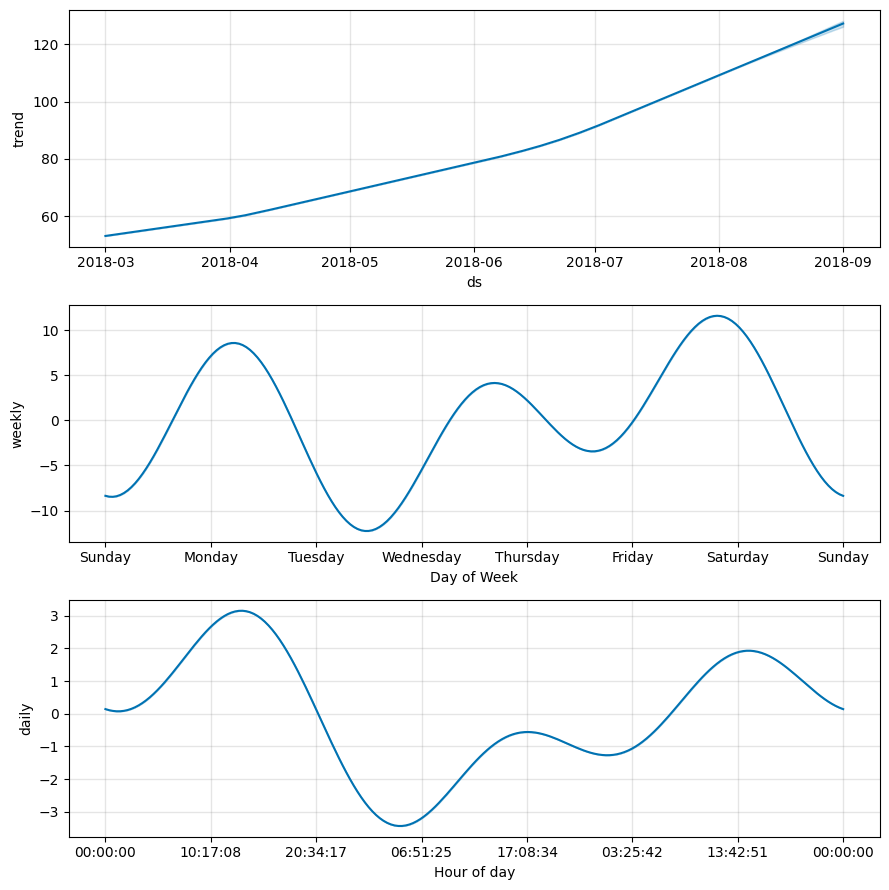

In [ ]:
# Построим графики
fig = model.plot_components(forecast)
fig.show()

In [ ]:
# Оценка предсказанных данных

# Вычислим метрики
y_true = test['y']
y_pred = forecast_test['yhat']

rmse = mean_squared_error(y_true, y_pred)**0.5
mae = mean_absolute_error(y_true, y_pred)


print(f"RMSE тестовой выборки Prophets: {rmse}")
print(f"MAE тестовой выборки Prophets: {mae}")

RMSE тестовой выборки Prophets: 54.72589876561613
MAE тестовой выборки Prophets: 40.65934580410908




---



# ARIMA

Применим модуль **ARIMA** для анализа нашего исходного датасета

In [ ]:
df = pd.read_csv('/content/taxi.csv', parse_dates=[0])
df.sort_index(inplace=True)

In [ ]:
# Зададим индексы в виде datetime
df = df.set_index('datetime')

In [ ]:
# Выполним ресемплирование данных по одному часу
df = df.resample('1H').sum()

In [ ]:
# Устраним выбросы
# Параметры скользящего окна
window_size = 4  # 4 часа

# Скользящее среднее и стандартное отклонение
rolling_mean = df['num_orders'].rolling(window=window_size).mean()
rolling_std = df['num_orders'].rolling(window=window_size).std()

# Определение границ
upper_bound = rolling_mean + 3 * rolling_std
lower_bound = rolling_mean - 3 * rolling_std

# Условие для выбросов
is_outlier = (df['num_orders'] < lower_bound) | (df['num_orders'] > upper_bound)

# Заменяем выбросы на значения скользящего среднего
df.loc[is_outlier, 'num_orders'] = rolling_mean[is_outlier]

In [ ]:
# Подбор параметров ARIMA
stepwise_model = auto_arima(df['num_orders'], trace=True)
print(stepwise_model.summary())

# Полученные параметры
p, d, q = stepwise_model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44886.781, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44502.251, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44355.432, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44884.782, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=44353.436, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43750.780, Time=1.97 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=2.39 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=1.80 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 39.

In [ ]:
# Разделим данные на тренировочную и тестовую выборку
train = df.iloc[:-31*24]  # Все данные, кроме последнего месяца
test = df.iloc[-31*24:]  # Последний месяц

In [ ]:
# Обучение модели
model = ARIMA(train['num_orders'], order=(p, d, q))
arima_result = model.fit()

# Вывод краткого отчета модели
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3672
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -17759.538
Date:                Mon, 27 Jan 2025   AIC                          35525.075
Time:                        13:54:37   BIC                          35543.700
Sample:                    03-01-2018   HQIC                         35531.706
                         - 07-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6368      0.014    -44.888      0.000      -0.665      -0.609
ma.L2         -0.3515      0.014    -24.913      0.000      -0.379      -0.324
sigma2       931.4460     17.156     54.291      0.0

In [ ]:
# Прогноз на тестовый период
forecast = arima_result.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Добавим в тестовую выборку предсказания
test['forecast'] = forecast_values

In [ ]:
# Метрики
y_true = test['num_orders']
y_pred = test['forecast']

rmse = mean_squared_error(y_true, y_pred)**0.5
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE тестовой выборки ARIMA: {rmse}")
print(f"MAE тестовой выборки ARIMA: {mae}")

RMSE тестовой выборки ARIMA: 59.54953244484798
MAE тестовой выборки ARIMA: 44.10873572516097




---



# LSTM

In [ ]:
df = pd.read_csv('/content/taxi.csv', parse_dates=[0])
df.sort_index(inplace=True)
# Зададим индексы в виде datetime
df = df.set_index('datetime')

In [ ]:
# Выполним ресемплирование данных по одному часу
df = df.resample('1H').sum()

In [ ]:
# Устраним выбросы
# Параметры скользящего окна
window_size = 4  # 4 часа

# Скользящее среднее и стандартное отклонение
rolling_mean = df['num_orders'].rolling(window=window_size).mean()
rolling_std = df['num_orders'].rolling(window=window_size).std()

# Определение границ
upper_bound = rolling_mean + 3 * rolling_std
lower_bound = rolling_mean - 3 * rolling_std

# Условие для выбросов
is_outlier = (df['num_orders'] < lower_bound) | (df['num_orders'] > upper_bound)

# Заменяем выбросы на значения скользящего среднего
df.loc[is_outlier, 'num_orders'] = rolling_mean[is_outlier]

In [ ]:
# Масштабируем данные
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['num_orders'].values.reshape(-1, 1))

In [ ]:
# Создадим последовательности для обучения
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])  # Последовательности
        y.append(data[i + time_steps, 0])    # Целевые значения
    return np.array(X), np.array(y)

time_steps = 24  # Длина последовательности
X, y = create_sequences(scaled_data, time_steps)

In [ ]:
# Разделим данные тренировочные и тестовые
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Добавим дополнительное измерение для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Построим модель
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Обучим модель
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0105 - val_loss: 0.0190
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - val_loss: 0.0155
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0149
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0162
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0114
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0104
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 0.0107
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0096
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0085
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0093
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

In [ ]:
# Прогноз для тестовых данных
y_pred = model.predict(X_test)

# Преобразование значений обратно в исходный масштаб
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Оценим метрики
rmse = mean_squared_error(y_test_original, y_pred_original)**0.5
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"RMSE тестовой выборки LSTM: {rmse}")
print(f"MAE тестовой выборки LSTM: {mae}")

RMSE тестовой выборки LSTM: 39.31052504342013
MAE тестовой выборки LSTM: 28.631644736106622




---



**Общий вывод**:

1. Мы загрузили и проанализировали данные. Сделали ресемплирование по одному часу.

2. Проверили данные на тренды и сезонность:
* График скользящего среднего подтвердил рост числа заказов к августу, что может быть связано с увеличением пассажиропотока.

* Декомпозиция данных показала восходящий тренд и дневную сезонность, где пик заказов приходится на полночь, а спад — на раннее утро.

3. Применён тест Дики-Фуллера, который показал, что данные стационарны.

4. Были выявлены выбросы, которые заменены на значения скользящего среднего, что исключило их влияние на модели.

5. Для классических моделей были созданы дополнительные признаки  (день недели, час, лаговые значения), которые улучшили способность моделей захватывать временные зависимости.

6. Были обучены и протестированы следующие модели:

* **LinearRegression** (RSME=46.77, MAE=36.58);

* **RandomForestRegressor** (RSME=39.09, MAE=29.08);

* **LGBMRegressor** (RSME=39.27, MAE=29.00);

* **Prophets** (RSME=54.72, MAE=40.66);

* **ARIMA** (RSME=59.55, MAE=44.11);

* **LSTM** (RSME=39.31, MAE=28.63).

Все модели прошли проверки на адекватность с baseline (RSME=71.32, MAE=60.20).

Лучше всего себя показали модели **LSTM**, **LGBMRegressor** и **RandomForest**.
